# AutoKeras implementation 

This notebook uses Autokeras, an automated machine learning library built upon Tensorflow and Keras. The goal of AutoKeras is to make machine learning accessible for everyone.

This example takes a real-life dataset [dogs vs cat](https://www.kaggle.com/c/dogs-vs-cats/data) and tries to train a well working image classifier without a user who decides which layers to use.

Please make sure that your driver configuration is correct (using Nvidia CUDA and cuDNN) and that the library makes its calculations on a GPU. Note that this code is written for AutoKeras v1.0.2 and may be updated for future versions.

Thank you for reading and enjoy exploring AutoKeras!

Robbe Decorte

## Global imports and declarations

In [1]:
!pip install autokeras
!pip install keras
!pip install tensorflow==2.1.0

     |████████████████████████████████| 67 kB 2.5 MB/s 
     |████████████████████████████████| 54 kB 1.8 MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-py3-none-any.whl size=73198 sha256=e5bd1b0d3af0e18e7bae1a0cc11169d6a039581c2d722537f7f54f93be3cbe13
  Stored in directory: /root/.cache/pip/wheels/33/f0/c8/218919df808b66696bdb2fbc2261ae74412383483226b0b31d
  Created wheel for terminaltables: filename=terminaltables-3.1.0-py3-none-any.whl size=15354 sha256=162b4d1135b2b0585d4342696b20d9fdf223521b69499e9b669977d05f662930
  Stored in directory: /root/.cache/pip/wheels/86/1b/58/c23af2fe683acd8edc15d5a1268f0242be1ff2cf827fe34737
Successfully built keras-tuner terminaltables


In [1]:
import pandas as pd
import numpy as np
import autokeras as ak
import tensorflow as tf

MAX_TRIES=10
SIZE=64
OUTPUT_NAME="autokeras-model-10"

## Verify GPU status

In [3]:
# Use the Keras GPU package
# conda install -c anaconda keras-gpu
from tensorflow.python.client import device_lib

In [4]:
# Show detailed information about the usable devices for Tensoflow
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8191629373662322934
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6936811501936359252
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 769252191931012629
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15870492672
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5947298733940490361
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [5]:
# Only request device names
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:GPU:0']


## Verify TPU status

In [6]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

ValueError: Please provide a TPU Name to connect to.

## Shuffle data and convert to numpy array

In [7]:
import os
from tqdm import tqdm
from PIL import Image
from random import shuffle

INPUT_PATH="data/train/"

In [8]:
def get_label(file):
    class_label = file.split('.')[0]
    if class_label == 'dog': label_vector = 0
    elif class_label == 'cat': label_vector = 1
    return label_vector

In [9]:
def get_data():
    data = []
    files = os.listdir(INPUT_PATH)
    for image in tqdm(files):
        
        label_vector = get_label(image)

        img = Image.open(INPUT_PATH + image).convert('L')
        img = img.resize((SIZE,SIZE))
        
        data.append([np.asarray(img),np.array(label_vector)])
        
    shuffle(data)
    return data

In [10]:
data = get_data()

FileNotFoundError: [Errno 2] No such file or directory: 'data/train/'

In [11]:
# Save the data as a numpy array
np.save('data/images_shuffled.npy', data)

NameError: name 'data' is not defined

## Data preprocessing and split to test and train

In [12]:
data = np.load('../input/catvsdog/images_shuffled.npy', allow_pickle=True)

# Split the labled data in train (20000 images) and test (5000 images)
train = data[:20000]
test = data[20000:]

print("Training dataset contains %d items" % len(train))
print("Testing dataset contains %d items" % len(test))

Training dataset contains 20000 items
Testing dataset contains 5000 items


In [13]:
x_train = np.array([data[0] for data in train], 'float32')
x_test = np.array([data[0] for data in test], 'float32')
y_train = [data[1] for data in train]
y_test = [data[1] for data in test]

In [14]:
x_train = np.array(x_train).reshape(-1,SIZE,SIZE,1)
x_test = np.array(x_test).reshape(-1,SIZE,SIZE,1)

x_train /= 255
x_test /= 255

y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(20000, 64, 64, 1)
(20000,)
(5000, 64, 64, 1)
(5000,)


## Training and model evaluation

In [15]:
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync

NameError: name 'tpu' is not defined

In [16]:
# Init image classifier.
clf = ak.ImageClassifier(max_trials=MAX_TRIES, name=OUTPUT_NAME)
# Feed the image classifier with training data.
clf.fit(x_train,y_train, verbose=2)

Train for 500 steps, validate for 125 steps
Epoch 1/1000
500/500 - 9s - loss: 0.5969 - accuracy: 0.6709 - val_loss: 0.5328 - val_accuracy: 0.7345
Epoch 2/1000
500/500 - 5s - loss: 0.4962 - accuracy: 0.7604 - val_loss: 0.5002 - val_accuracy: 0.7580
Epoch 3/1000
500/500 - 5s - loss: 0.4469 - accuracy: 0.7914 - val_loss: 0.4882 - val_accuracy: 0.7665
Epoch 4/1000
500/500 - 5s - loss: 0.4074 - accuracy: 0.8138 - val_loss: 0.4809 - val_accuracy: 0.7740
Epoch 5/1000
500/500 - 6s - loss: 0.3760 - accuracy: 0.8324 - val_loss: 0.4787 - val_accuracy: 0.7855
Epoch 6/1000
500/500 - 5s - loss: 0.3446 - accuracy: 0.8470 - val_loss: 0.4921 - val_accuracy: 0.7768
Epoch 7/1000
500/500 - 5s - loss: 0.3300 - accuracy: 0.8540 - val_loss: 0.5020 - val_accuracy: 0.7780
Epoch 8/1000
500/500 - 5s - loss: 0.3105 - accuracy: 0.8641 - val_loss: 0.5147 - val_accuracy: 0.7818
Epoch 9/1000
500/500 - 5s - loss: 0.2879 - accuracy: 0.8724 - val_loss: 0.5144 - val_accuracy: 0.7828
Epoch 10/1000
500/500 - 5s - loss: 0.2

Train for 500 steps, validate for 125 steps
Epoch 1/1000
500/500 - 34s - loss: 0.6702 - accuracy: 0.6327 - val_loss: 1.7642 - val_accuracy: 0.6018
Epoch 2/1000
500/500 - 25s - loss: 0.5742 - accuracy: 0.7094 - val_loss: 0.6446 - val_accuracy: 0.6720
Epoch 3/1000
500/500 - 26s - loss: 0.5061 - accuracy: 0.7554 - val_loss: 0.5576 - val_accuracy: 0.7475
Epoch 4/1000
500/500 - 24s - loss: 0.4399 - accuracy: 0.7978 - val_loss: 0.7505 - val_accuracy: 0.6755
Epoch 5/1000
500/500 - 26s - loss: 0.3930 - accuracy: 0.8217 - val_loss: 0.5480 - val_accuracy: 0.7632
Epoch 6/1000
500/500 - 25s - loss: 0.3363 - accuracy: 0.8537 - val_loss: 0.5463 - val_accuracy: 0.8018
Epoch 7/1000
500/500 - 25s - loss: 0.2918 - accuracy: 0.8740 - val_loss: 0.4841 - val_accuracy: 0.7935
Epoch 8/1000
500/500 - 25s - loss: 0.2442 - accuracy: 0.8974 - val_loss: 0.4981 - val_accuracy: 0.8018
Epoch 9/1000
500/500 - 24s - loss: 0.2036 - accuracy: 0.9146 - val_loss: 0.5584 - val_accuracy: 0.7930
Epoch 10/1000
500/500 - 25s -

Train for 500 steps, validate for 125 steps
Epoch 1/1000
500/500 - 6s - loss: 0.6150 - accuracy: 0.6508 - val_loss: 0.5574 - val_accuracy: 0.7107
Epoch 2/1000
500/500 - 5s - loss: 0.5161 - accuracy: 0.7468 - val_loss: 0.5063 - val_accuracy: 0.7520
Epoch 3/1000
500/500 - 5s - loss: 0.4628 - accuracy: 0.7809 - val_loss: 0.4939 - val_accuracy: 0.7617
Epoch 4/1000
500/500 - 5s - loss: 0.4286 - accuracy: 0.8037 - val_loss: 0.5143 - val_accuracy: 0.7525
Epoch 5/1000
500/500 - 5s - loss: 0.3940 - accuracy: 0.8198 - val_loss: 0.4961 - val_accuracy: 0.7632
Epoch 6/1000
500/500 - 5s - loss: 0.3682 - accuracy: 0.8362 - val_loss: 0.5136 - val_accuracy: 0.7660
Epoch 7/1000
500/500 - 5s - loss: 0.3416 - accuracy: 0.8490 - val_loss: 0.5055 - val_accuracy: 0.7763
Epoch 8/1000
500/500 - 5s - loss: 0.3244 - accuracy: 0.8549 - val_loss: 0.5014 - val_accuracy: 0.7740
Epoch 9/1000
500/500 - 5s - loss: 0.3047 - accuracy: 0.8659 - val_loss: 0.5187 - val_accuracy: 0.7775
Epoch 10/1000
500/500 - 5s - loss: 0.2

Train for 625 steps, validate for 125 steps
Epoch 1/1000
625/625 - 7s - loss: 0.5768 - accuracy: 0.6890 - val_loss: 0.4546 - val_accuracy: 0.8048
Epoch 2/1000
625/625 - 6s - loss: 0.4862 - accuracy: 0.7693 - val_loss: 0.3827 - val_accuracy: 0.8480
Epoch 3/1000
625/625 - 6s - loss: 0.4432 - accuracy: 0.7925 - val_loss: 0.3657 - val_accuracy: 0.8550
Epoch 4/1000
625/625 - 6s - loss: 0.4109 - accuracy: 0.8145 - val_loss: 0.3114 - val_accuracy: 0.8823
Epoch 5/1000
625/625 - 6s - loss: 0.3826 - accuracy: 0.8274 - val_loss: 0.2755 - val_accuracy: 0.9032
Epoch 6/1000
625/625 - 6s - loss: 0.3571 - accuracy: 0.8409 - val_loss: 0.2440 - val_accuracy: 0.9168
Epoch 7/1000
625/625 - 7s - loss: 0.3372 - accuracy: 0.8511 - val_loss: 0.2111 - val_accuracy: 0.9337
Epoch 8/1000
625/625 - 7s - loss: 0.3150 - accuracy: 0.8625 - val_loss: 0.1882 - val_accuracy: 0.9415
Epoch 9/1000
625/625 - 6s - loss: 0.3024 - accuracy: 0.8680 - val_loss: 0.1962 - val_accuracy: 0.9275
Epoch 10/1000
625/625 - 6s - loss: 0.2

In [17]:

clf = ak.AutoModel(inputs=[ak.ImageInput()], outputs=[ak.ClassificationHead()], tuner="random", max_trials=MAX_TRIES, name=OUTPUT_NAME, overwrite=False)
clf.fit(x_train, y_train, verbose=2, epochs=150)

RuntimeError: Error reloading `Oracle` from existing project. If you did not mean to reload from an existing project, change the `project_name` or pass `overwrite=True` when creating the `Tuner`. Found existing project at: ./autokeras-model-10

In [18]:
score = clf.evaluate(x_test, y_test)

157/157 [==============================] - 1s 5ms/step - loss: 0.7110 - accuracy: 0.8138


In [19]:
print('Accuracy: {accuracy}\nLoss: {loss}'.format(accuracy=score[1], loss=score[0]))

Accuracy: 0.8137999773025513
Loss: 0.7110067240561649


In [20]:
model = clf.export_model()
model.save(OUTPUT_NAME + '/model.h5')
print('Model succesfully exported')
print(type(model))

Model succesfully exported
<class 'tensorflow.python.keras.engine.training.Model'>


## Model visualization

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
from tensorflow.python.keras.models import load_model
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score

In [22]:
# Load model
cust = ak.CUSTOM_OBJECTS
cust['Normalization'] = Normalization

model = load_model(OUTPUT_NAME+'/model.h5', custom_objects=cust)

print("Model succesfully loaded")

Model succesfully loaded


In [23]:
score = model.evaluate(x_test, y_test)

5000/5000 [==============================] - 1s 144us/sample - loss: 0.7097 - accuracy: 0.8138


In [24]:
print('Accuracy: {accuracy}\nLoss: {loss}'.format(accuracy=score[1], loss=score[0]))

Accuracy: 0.8137999773025513
Loss: 0.7096773278236389


In [25]:
predictions = model.predict(x_test)

Text(90.80000000000001, 0.5, 'predicted category')

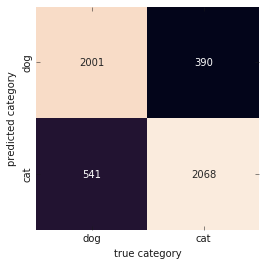

In [26]:
plt.style.use('classic')
%matplotlib inline

mat = confusion_matrix(y_test, predictions.round())
labels = ['dog', 'cat']

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('true category')
plt.ylabel('predicted category')

In [27]:
instances = 0
correct_ones = 0

images = x_test.reshape(5000,64, 64)
incorrect_predictions = []

for i in range(0, len(predictions)):
    if i < 5:
        print("Prediction: ", predictions[i], ", Actual: ", y_test[i])
    if predictions[i].round() == y_test[i]:
        correct_ones += 1
    else:
        incorrect_predictions.append((i, images[i], predictions[i].round(4), y_test[i]))
    instances += 1
    
print('\nMade {amountPred} predictions. {amountCorrect} of those are correct. Approximately {percentage}%.'
      .format(amountPred=instances, amountCorrect=correct_ones, percentage=round((correct_ones/instances) * 100)))

Prediction:  [0.80770755] , Actual:  0
Prediction:  [0.04540604] , Actual:  0
Prediction:  [0.00414185] , Actual:  0
Prediction:  [3.5905956e-08] , Actual:  0
Prediction:  [0.99787474] , Actual:  1

Made 5000 predictions. 4069 of those are correct. Approximately 81%.


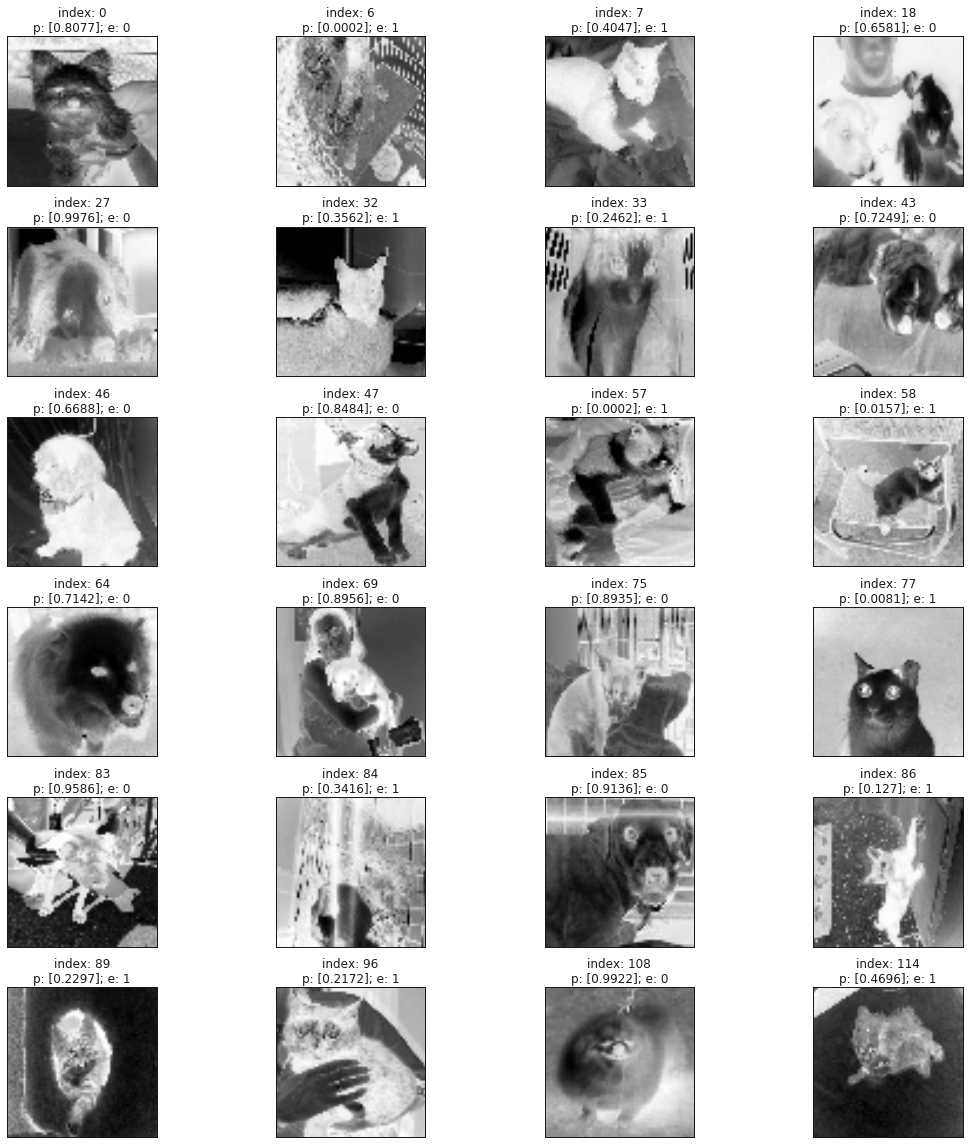

In [28]:
# Show images that are classified to the wrong class
# Dog = 0, Cat = 1
%matplotlib inline

figure, axes = plt.subplots(nrows=6, ncols=4, figsize=(16,16))

for axes, item in zip(axes.ravel(), incorrect_predictions):
    index, image, predicted, expected = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_title(f'index: {index}\np: {predicted}; e: {expected}')
plt.tight_layout()

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
normalization (Normalization (None, 64, 64, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0     

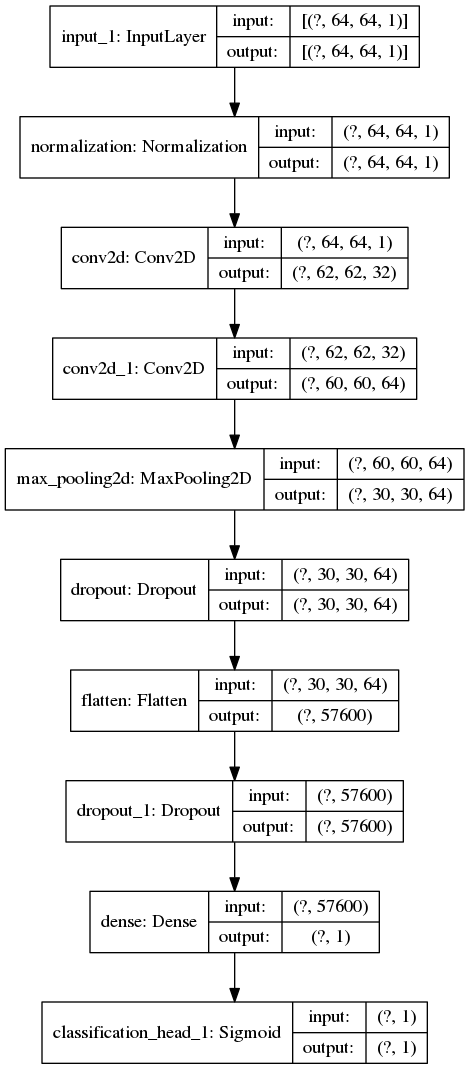

In [30]:
plot_model(model, to_file=OUTPUT_NAME + '/model.png', show_shapes=True, show_layer_names=True)